<h1><center>Predicting NBA Game Attendance Using Numerous Regression Techniques </center></h1>

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import src.data.datasets as ds
import src.data.train_test_split as split
import src.features.clustering as clustering
import src.features.decomposition as decomposition
import src.features.statistical_tests as st
import src.initialize_jupyter
import src.models.ensemble_models as ensembles
import src.models.linear_models as linear_models
import src.models.metrics as metrics
import src.models.neural_networks as nn
import src.models.other_models as other_models
import src.visualization.data_exploration as de

Using TensorFlow backend.


## Load data
---
This data was originally scraped from multiple sources and includes game data since the 1998-1999 season.\
Three datasets have been created for use with many regression techniques:
- dataset_1: Game data since January, 2004 that includes Google Trends monthly popularity data per team, filtering of games based on usage of current day stadia, and stadium capacities )
- dataset_2: Game data since Fall, 1998 not including popularity, filtering, or capacities
- dataset_3: Game data since 1990 including filtering and capacities, but not popularity

In [29]:
ds.create_datasets()

In [2]:
datasets = ds.load_datasets()
datasets['3']

,V Pop,H Pop,Curr Win %,LS Win %,Last Game,Last Attendance vs Opp,Capacity,Visitor,Playoffs?,Last Five,Day of Week,Month,Rivalry?,Attendance
Time,,,,,,,,,,,,,,
2004-01-02 19:00:00,3.0,3.0,0.333333,0.465753,13897.0,15108.0,20173.0,Golden State Warriors,0.0,1.0,Friday,January,0.0,12466.0
2004-01-02 19:30:00,4.0,9.0,0.689655,0.556962,18624.0,18624.0,18624.0,Indiana Pacers,0.0,4.0,Friday,January,0.0,18624.0
2004-01-02 19:30:00,19.0,2.0,0.275862,0.338028,16500.0,19600.0,20213.0,Orlando Magic,0.0,1.0,Friday,January,1.0,15864.0
2004-01-02 20:00:00,5.0,2.0,0.714286,0.625000,20092.0,17093.0,20391.0,Atlanta Hawks,0.0,4.0,Friday,January,0.0,17074.0
2004-01-02 22:00:00,4.0,2.0,0.481481,0.580247,17237.0,19372.0,20630.0,Denver Nuggets,0.0,2.0,Friday,January,0.0,17316.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06 20:00:00,0.0,0.0,0.700000,0.747253,19156.0,18624.0,19156.0,Denver Nuggets,0.0,2.0,Friday,December,0.0,19156.0
2019-12-06 20:00:00,0.0,0.0,0.428571,0.655172,18203.0,18203.0,18203.0,Minnesota Timberwolves,0.0,3.0,Friday,December,0.0,18203.0
2019-12-06 20:30:00,0.0,0.0,0.391304,0.573034,18354.0,18354.0,18627.0,Sacramento Kings,0.0,3.0,Friday,December,0.0,18354.0


## Create train-test split of dataset and one hot encode categorical features
---

In [3]:
X_train, X_test, y_train, y_test, train = split.split(datasets['3'])
print("{} observations in training set".format(len(X_train), len(X_train.columns)))
print("{} observations in test set".format(len(X_test), len(X_test.columns)))
print("Features: {}:6 numerical, 84 binary categorical; Response: 1 numerical".format(len(X_test.columns)))
X_train.head()

11133 observations in training set
3711 observations in test set
Features: 61:6 numerical, 84 binary categorical; Response: 1 numerical


,V Pop,H Pop,Curr Win %,LS Win %,Last Game,Last Attendance vs Opp,Capacity,Playoffs?,Rivalry?,Visitor_Atlanta Hawks,...,Month_March,Month_May,Month_November,Month_October,Last Five_0.0,Last Five_1.0,Last Five_2.0,Last Five_3.0,Last Five_4.0,Last Five_5.0
Time,,,,,,,,,,,,,,,,,,,,,
2004-01-02 19:00:00,3.0,3.0,0.333333,0.465753,13897.0,15108.0,20173.0,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
2004-01-02 19:30:00,4.0,9.0,0.689655,0.556962,18624.0,18624.0,18624.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
2004-01-02 19:30:00,19.0,2.0,0.275862,0.338028,16500.0,19600.0,20213.0,0.0,1.0,0,...,0,0,0,0,0,1,0,0,0,0
2004-01-02 20:00:00,5.0,2.0,0.714286,0.625000,20092.0,17093.0,20391.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
2004-01-02 22:00:00,4.0,2.0,0.481481,0.580247,17237.0,19372.0,20630.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0


## Visualizations for data exploration and feature engineering/selection
---

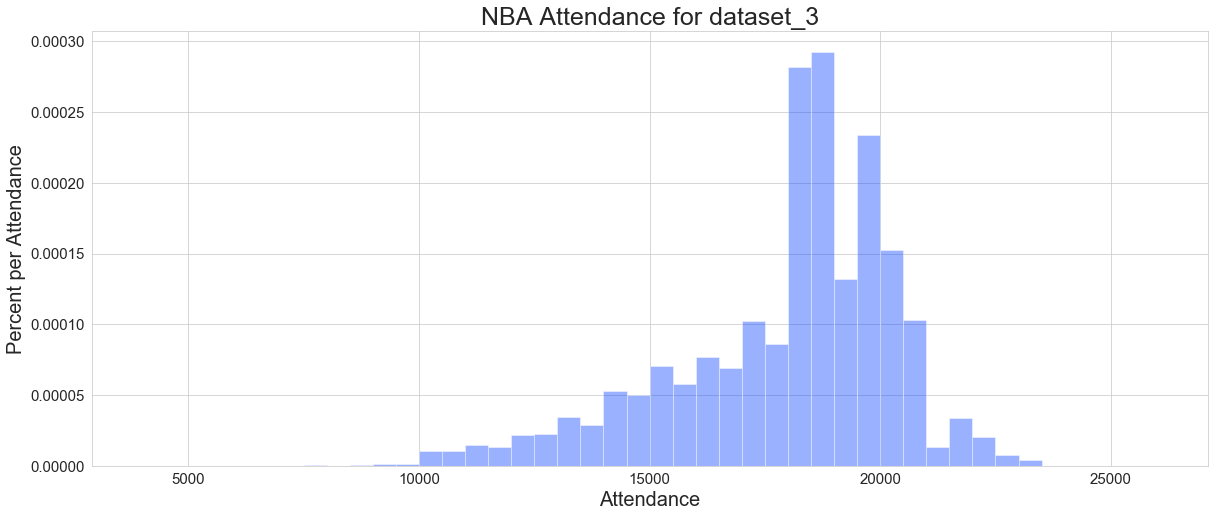

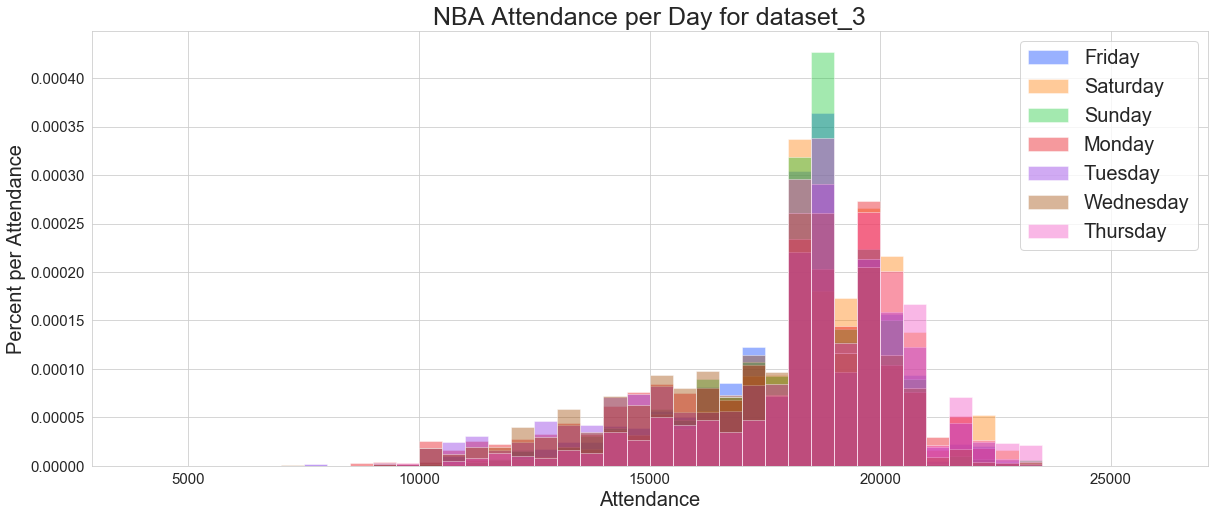

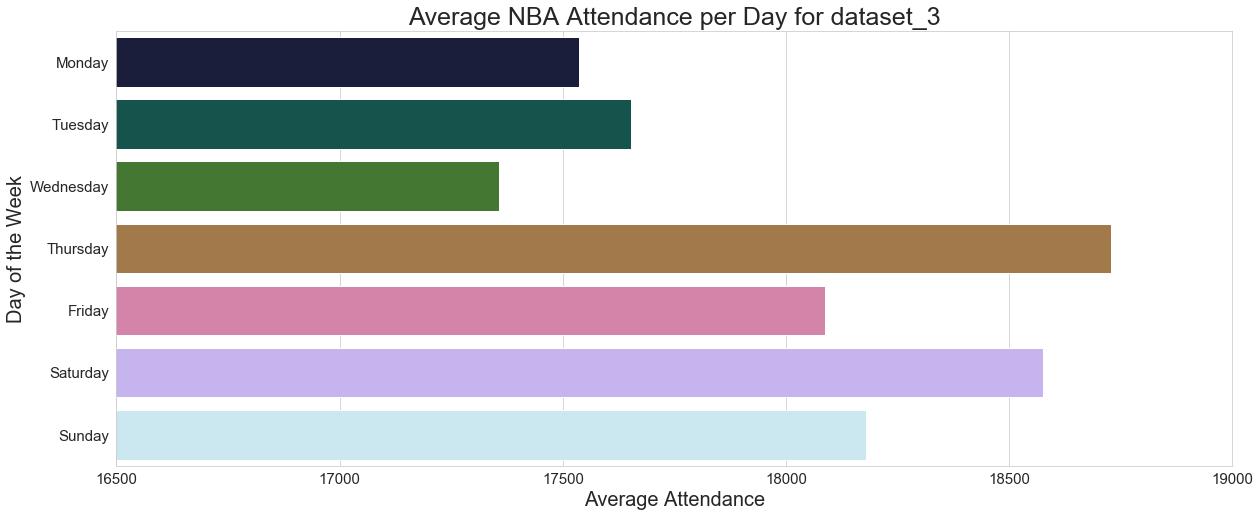

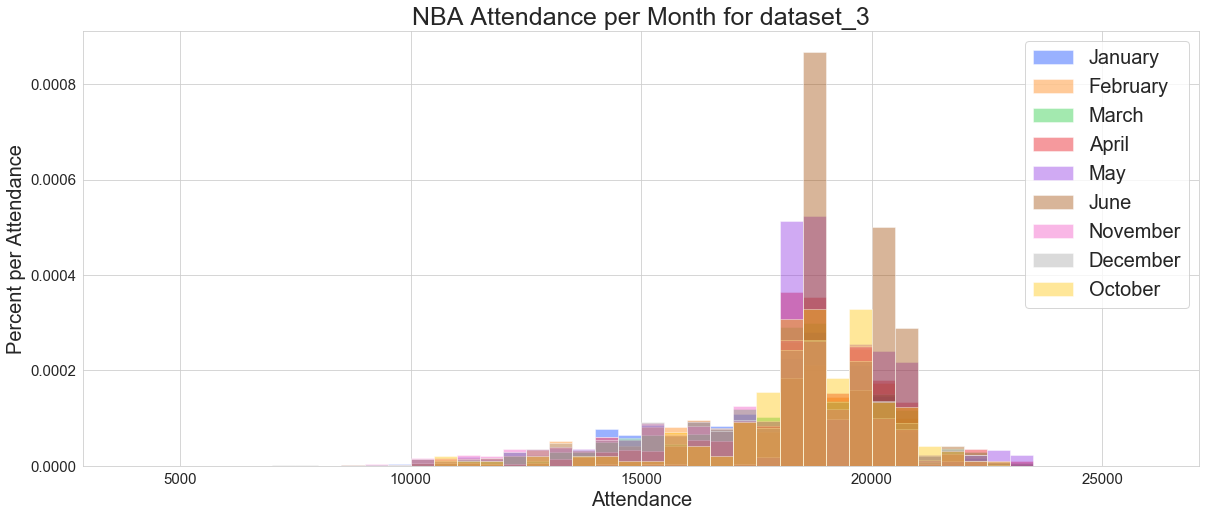

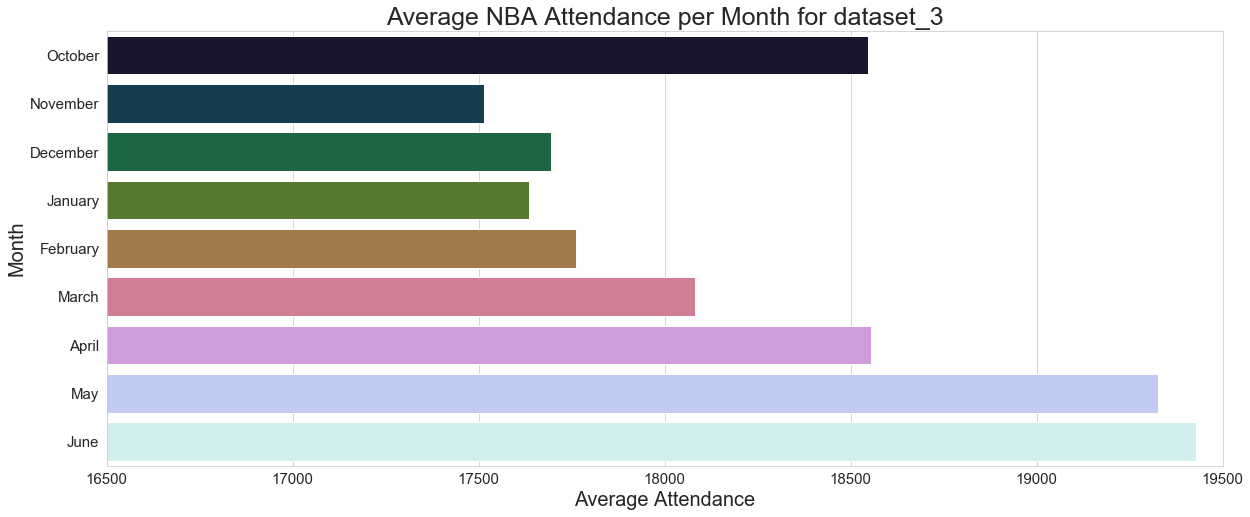

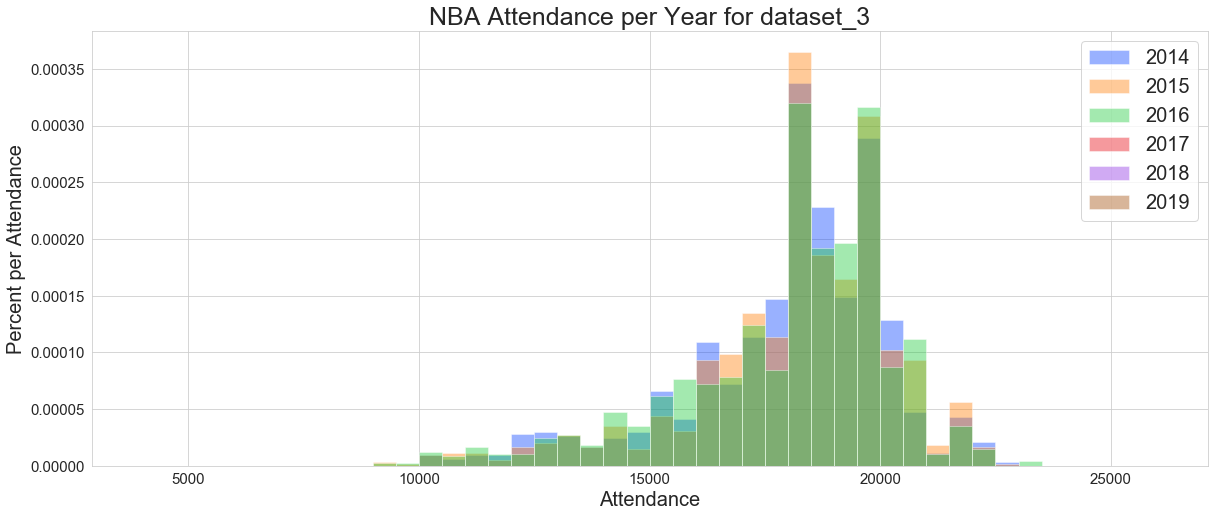

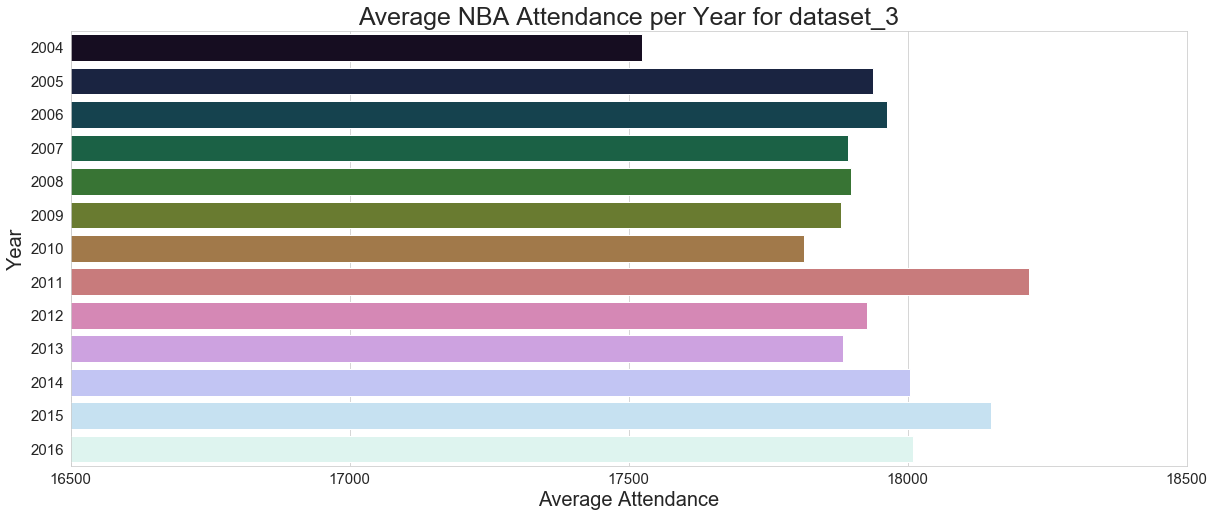

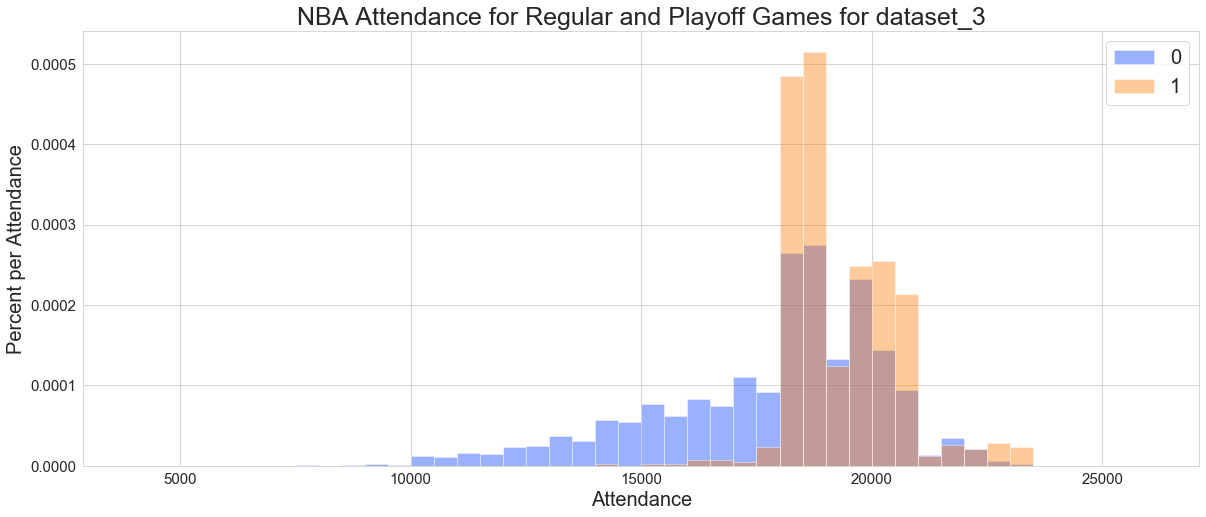

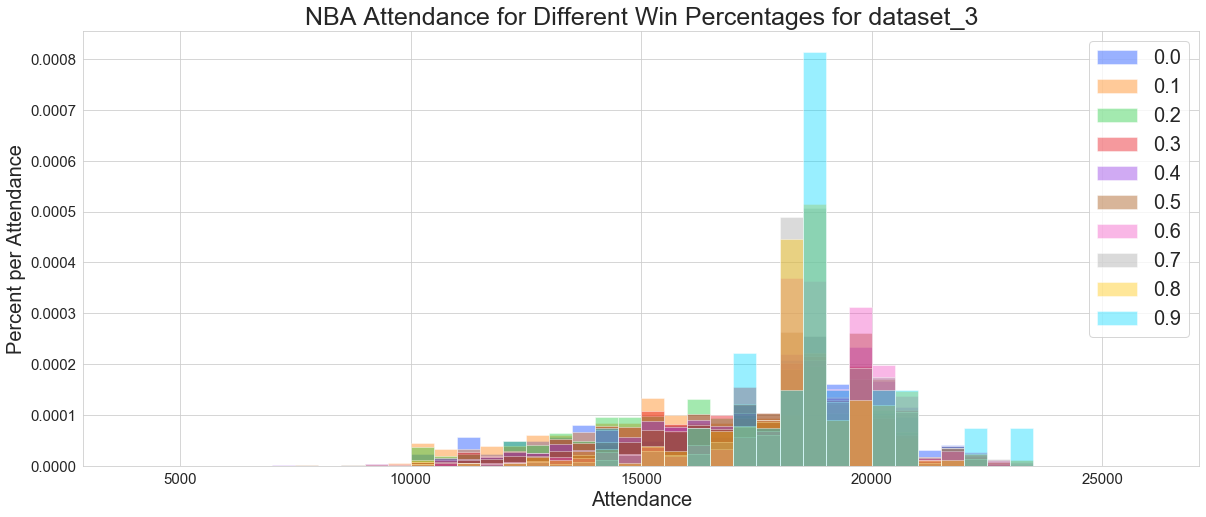

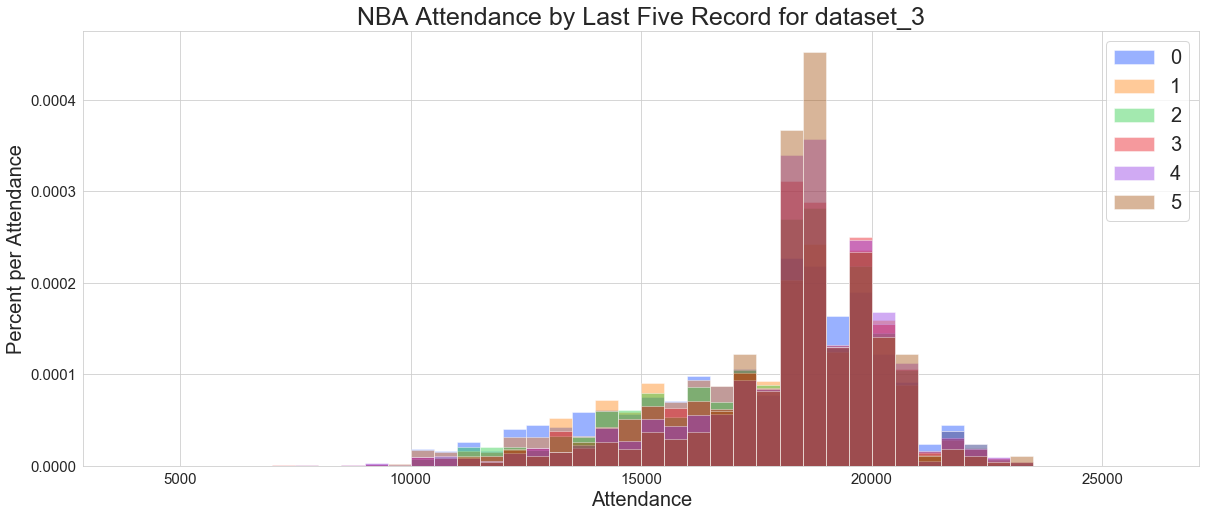

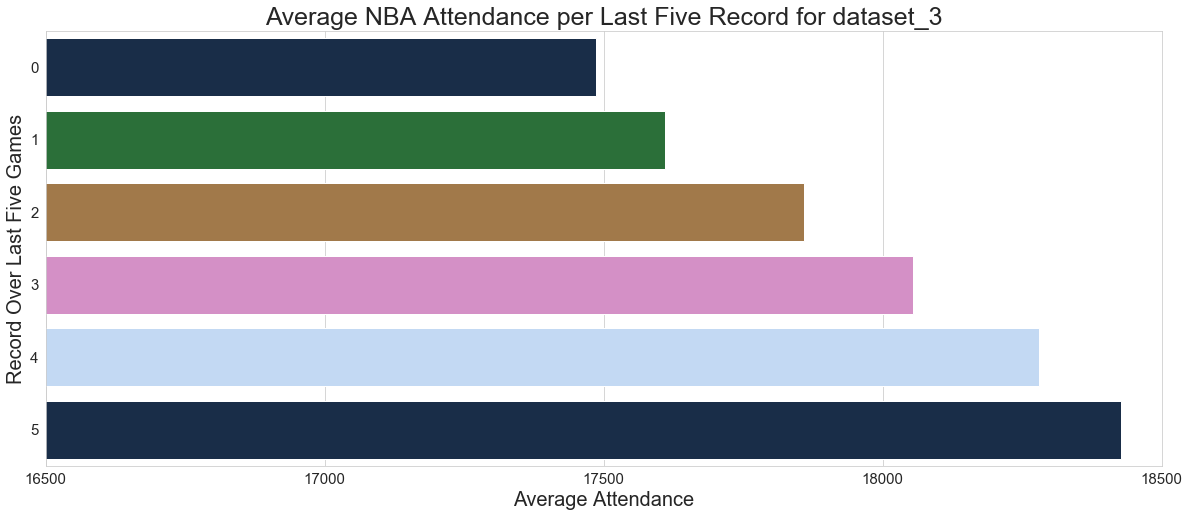

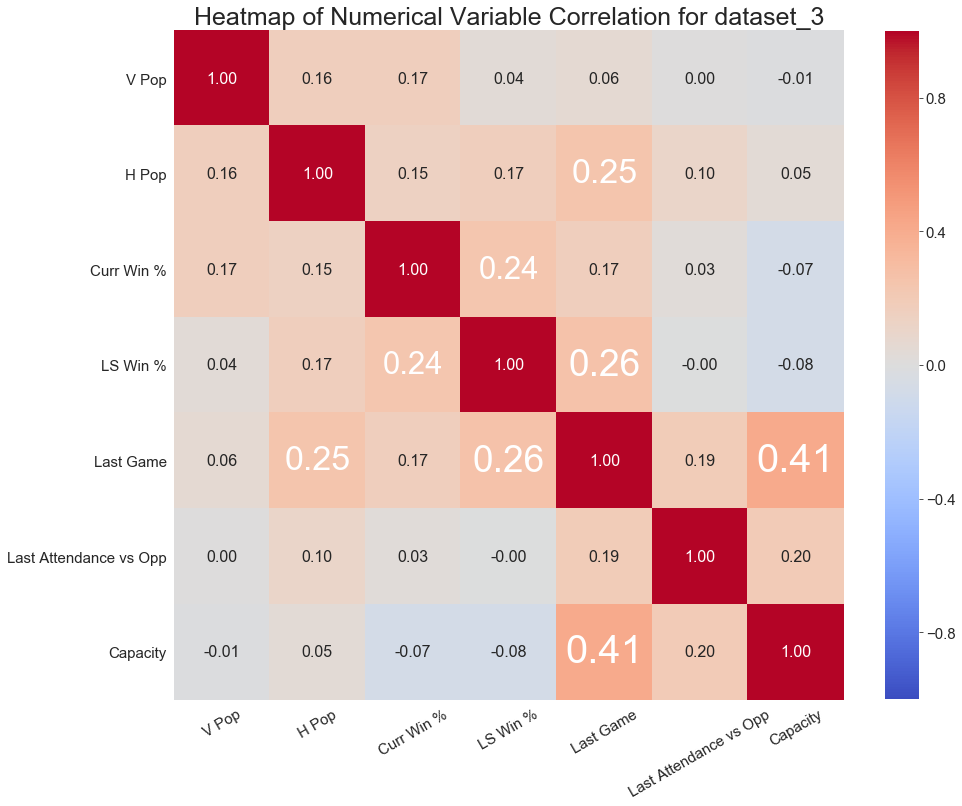

In [5]:
de.create_all_plots('dataset_3', train)

In [7]:
decomposition.pca_component_analysis('dataset_3', X_train)

AttributeError: module 'src.features.decomposition' has no attribute 'pca_component_analysis'

In [6]:
decomposition.pca_cv('dataset_3',X_train,X_test,y_train,y_test)

,R^2,Explained Variance Score,Mean Absolute Error,Root Mean Square Error,Mean Absolute Percent Error
dataset_3: 1 dimensions,0.442040,0.442425,1179.965946,1520.166867,6.925159
dataset_3: 2 dimensions,0.481894,0.482203,1115.174751,1464.869538,6.592910
dataset_3: 3 dimensions,0.474735,0.475122,1123.102196,1474.956060,6.645135
dataset_3: 4 dimensions,0.511669,0.512444,1074.113447,1422.155491,6.368992
dataset_3: 5 dimensions,0.517672,0.518717,1067.454594,1413.386717,6.333800
dataset_3: 6 dimensions,0.516154,0.516694,1068.665858,1415.608701,6.342730


In [8]:
clustering.elbow_method_kmeans('dataset_3', X_train)

KeyboardInterrupt: 

In [ ]:
clustering.elbow_method_kmeans('dataset_3', X_train, 25,6)

In [ ]:
clustering.silhouettes('dataset_3', X_train)

## Further consideration of feature selection through analytic metrics
---

In [9]:
st.collect_tests('dataset_3', X_train, y_train)v

,VIF Round 0,VIF Round 1,VIF Round 2,VIF Round 3,VIF Round 4,Numerical Feature Significance (P-Value) dataset_3,Estimated Mutual Information dataset_3
Capacity,81.456199,NaN,NaN,NaN,NaN,0.000000e+00,1.673327
Curr Win %,8.574264,8.538194,7.931815,6.317380,NaN,1.276136e-126,0.104632
H Pop,1.953125,1.892781,1.881437,1.851001,1.814744,9.055400e-155,0.491782
LS Win %,14.588915,14.458482,10.471326,NaN,NaN,6.238286e-173,1.390217
Last Attendance vs Opp,19.459601,16.687604,9.150215,6.121008,2.139492,9.623783e-91,0.715860
Last Game,79.852906,31.472500,NaN,NaN,NaN,0.000000e+00,1.286488
V Pop,1.725147,1.723022,1.716795,1.716351,1.639853,4.995610e-30,0.034865


### Creating subset of dataset_1 based on best guess of important features and preparing it for modeling

In [26]:
X_train, X_test,y_train, y_test  = [[],[],[],[]]

In [ ]:

    
    
    
dataset_1_0 = ds.create_dataset_1_1(dataset_1)
print("dataset_1_1 contains: {} observations; {} features: 4 numerical, 3 multiclass categorical, 2 binary categorical; 1 Response".format(len(dataset_1_1), len(dataset_1_1.columns)-1))
X_train_0, X_test_1, y_train_1, y_test_1, train_1 = split.split(dataset_1_1)
print("After split contains:")
print("{} observations in training set".format(len(X_train_1), len(X_train_1.columns)))
print("{} observations in test set".format(len(X_test_1), len(X_test_1.columns)))
print("28 features: 4 numerical, 24 binary categorical; 1 Response")

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1, train_1 = split.split(dataset_1_1)

## Modeling
---

### Start with linear models that generally have simpler hyperparameters to tune

In [5]:
linear_statistics = linear_models.collect_statistics('dataset_3', X_train, X_test, y_train, y_test)
                                                        
display(linear_statistics.sort_values(['Mean Absolute Error']).head())
display(linear_statistics.sort_values(['R^2'], ascending = False).head())
linear_statistics.sort_values(['Root Mean Square Error']).head()

,R^2,Explained Variance Score,Mean Absolute Error,Root Mean Square Error,Mean Absolute Percent Error
dataset_3 Elastic Net TimeSeriesSplit,0.454207,0.474133,851.959030,1503.500930,5.363255
dataset_3 Huber,0.454441,0.475746,853.215656,1503.178760,5.374350
dataset_3 Elastic Net with Standardized Features TimeSeriesSplit,0.523158,0.531259,917.690069,1405.325971,5.604023
dataset_3 Huber with Standardized Features,0.523158,0.531259,917.690069,1405.325971,5.604023
dataset_3 Elastic Net with PCA TimeSeriesSplit,0.523158,0.531259,917.690069,1405.325971,5.604023


,R^2,Explained Variance Score,Mean Absolute Error,Root Mean Square Error,Mean Absolute Percent Error
dataset_3 Ridge,0.55013,0.554212,1018.977863,1365.002688,6.049904
dataset_3 OLS TimeSeriesSplit,0.55013,0.554212,1018.977863,1365.002688,6.049904
dataset_3 OLS,0.55013,0.554212,1018.977904,1365.002719,6.049904
dataset_3 Elastic Net with PCA,0.54457,0.545400,998.499887,1373.412117,5.946689
dataset_3 Lasso with PCA TimeSeriesSplit,0.54457,0.545400,998.499887,1373.412117,5.946689


,R^2,Explained Variance Score,Mean Absolute Error,Root Mean Square Error,Mean Absolute Percent Error
dataset_3 Ridge,0.55013,0.554212,1018.977863,1365.002688,6.049904
dataset_3 OLS TimeSeriesSplit,0.55013,0.554212,1018.977863,1365.002688,6.049904
dataset_3 OLS,0.55013,0.554212,1018.977904,1365.002719,6.049904
dataset_3 Lasso with PCA TimeSeriesSplit,0.54457,0.545400,998.499887,1373.412117,5.946689
dataset_3 Ridge with PCA TimeSeriesSplit,0.54457,0.545400,998.499887,1373.412117,5.946689


In [13]:
linear_statistics 

NameError: name 'linear_statistics' is not defined

In [23]:

linear_statisticss.columns = ['Derp','Model', 'OSR^2', "Explained Variance Score", "Mean Absolute Error", "Root Mean Square Error", "Mean Absolute Percent Error"]
display(linear_statisticss.sort_values(['Mean Absolute Error'])[['Model', 'Mean Absolute Error']].head())
display(linear_statisticss.sort_values(['OSR^2'], ascending = False)[['Model', 'OSR^2']].head())
linear_statisticss.sort_values(['Root Mean Square Error'], ascending = True)[['Model', 'Root Mean Square Error']].head()

,Model,Mean Absolute Error
27,dataset_3 Elastic Net TimeSeriesSplit,851.959030
12,dataset_3 Huber,853.215656
28,dataset_3 Elastic Net with Standardized Featur...,917.690069
13,dataset_3 Huber with Standardized Features,917.690069
29,dataset_3 Elastic Net with PCA TimeSeriesSplit,917.690069


,Model,OSR^2
3,dataset_3 Ridge,0.55013
18,dataset_3 OLS TimeSeriesSplit,0.55013
0,dataset_3 OLS,0.55013
11,dataset_3 Elastic Net with PCA,0.54457
26,dataset_3 Lasso with PCA TimeSeriesSplit,0.54457


,Model,Root Mean Square Error
3,dataset_3 Ridge,1365.002688
18,dataset_3 OLS TimeSeriesSplit,1365.002688
0,dataset_3 OLS,1365.002719
26,dataset_3 Lasso with PCA TimeSeriesSplit,1373.412117
23,dataset_3 Ridge with PCA TimeSeriesSplit,1373.412117


### Next, ensemble methods 

In [ ]:
df = pd.DataFrame()
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, random_state = 18, criterion = 'mae').fit(X_train, y_train).predict(X_test)
rf = metrics.apply_metrics('dataset_3: {}'.format('rf'), y_test, rf.ravel())
ab = AdaBoostRegressor(n_jobs = -1, random_state = 18).fit(X_train, y_train).predict(X_test)
ab = metrics.apply_metrics('dataset_3: {}'.format('ab'), y_test, ab.ravel())
gbr = GradientBoostingRegressor(random_state = 18).fit(X_train, y_train).predict(X_test)
gbr = metrics.apply_metrics('dataset_3: {}'.format('gbr'), y_test, gbr.ravel())
et =  ExtraTreesRegressor(n_jobs = -1, random_state = 18)
et = metrics.apply_metrics('dataset_3: {}'.format('et'), y_test, et.ravel())
df = pd.concat([rf,ab,gbr,et], axis =0)

In [ ]:
df

In [ ]:
random_forest_cv = ensembles.random_forest_grid_cv(X_train, y_train, cv = 5)

In [ ]:
random_forest_cv_df = pd.DataFrame.from_dict(random_forest_cv.cv_results_)[['params', 'rank_test_R^2','mean_test_R^2','rank_test_Explained Variance Score', 'mean_test_Explained Variance Score',
                                                      'rank_test_Mean Absolute Error', 'mean_test_Mean Absolute Error', 'rank_test_Root Mean Square Error',
                                                      'mean_test_Root Mean Square Error','rank_test_Mean Absolute Percent Error',
                                                      'mean_test_Mean Absolute Percent Error']].sort_values(['rank_test_Mean Absolute Error', 
                                                                                                        'rank_test_R^2', 
                                                                                                        'rank_test_Root Mean Square Error',
                                                                                                        'rank_test_Explained Variance Score',
                                                                                                        'rank_test_Mean Absolute Percent Error'])
# random_forest_cv_df
random_forest_cv_df.head(10)['params'].values

In [ ]:
to_save = Path().resolve().joinpath('models', 'cross_validation_outcomes', '{}.csv'.format('random_forest_random_cv_1'))
random_forest_cv_df.to_csv(to_save)

In [ ]:
adaboost_cv = ensembles.adaboost_randomized_cv(X_train, y_train, n_iter = 25, cv = 5)

In [ ]:
adaboost_cv.cv_results_

In [ ]:
top_ten_by_all_rank = pd.DataFrame.from_dict(adaboost_cv.cv_results_)[['params', 'rank_test_R^2', 'rank_test_Explained Variance Score', 
                                                  'rank_test_Mean Absolute Error', 'rank_test_Root Mean Square Error',
                                                 'rank_test_Mean Absolute Percent Error']].sort_values(['rank_test_Mean Absolute Error', 
                                                                                                        'rank_test_R^2', 
                                                                                                        'rank_test_Explained Variance Score',                                                                                                    
                                                                                                        'rank_test_Root Mean Square Error',
                                                                                                        'rank_test_Mean Absolute Percent Error']).head(10)['params'].values
top_ten_by_all_rank

In [ ]:
gradient_boosting_cv = ensembles.gradient_boosting_randomized_cv(X_train, y_train, n_iter = 25, cv= 5)

In [ ]:
gradient_boosting_cv_boosting_cv.cv_results_

In [ ]:
top_ten_by_all_rank = pd.DataFrame.from_dict(gradient_boosting_cv.cv_results_)[['params', 'rank_test_R^2', 'rank_test_Explained Variance Score', 
                                                  'rank_test_Mean Absolute Error', 'rank_test_Root Mean Square Error',
                                                 'rank_test_Mean Absolute Percent Error']].sort_values(['rank_test_Mean Absolute Error', 
                                                                                                        'rank_test_Explained Variance Score',
                                                                                                        'rank_test_R^2', 
                                                                                                        'rank_test_Root Mean Square Error',
                                                                                                        'rank_test_Mean Absolute Percent Error']).head(10)['params'].values
top_ten_by_all_rank

In [ ]:
extra_trees_cv = ensembles.extra_trees_randomized_cv(X_train, y_train, n_iter = 25, cv = 5)

In [ ]:
extra_trees_cv.cv_results_

In [ ]:
top_ten_by_all_rank = pd.DataFrame.from_dict(extra_trees_cv.cv_results_)[['params', 'rank_test_R^2', 'rank_test_Explained Variance Score', 
                                                  'rank_test_Mean Absolute Error', 'rank_test_Root Mean Square Error',
                                                 'rank_test_Mean Absolute Percent Error']].sort_values(['rank_test_Mean Absolute Error', 
                                                                                                        'rank_test_Explained Variance Score',
                                                                                                        'rank_test_R^2', 
                                                                                                        'rank_test_Root Mean Square Error',
                                                                                                        'rank_test_Mean Absolute Percent Error']).head(10)['params'].values
top_ten_by_all_rank

### Other Models 

In [ ]:
k_neighbors_randomized = other_models.k_neighbors_randomized_cv(X_train, y_train, 25, 5)

In [ ]:
df = pd.DataFrame.from_dict(k_neighbors_randomized.cv_results_)
df[['params', 'mean_test_R^2', 'rank_test_R^2', 'rank_test_Explained Variance Score', 
                                                  'rank_test_Mean Absolute Error', 'rank_test_Root Mean Square Error',
                                                 'rank_test_Mean Absolute Percent Error']].sort_values(['rank_test_Mean Absolute Error', 
                                                                                                        'rank_test_Explained Variance Score',
                                                                                                        'rank_test_R^2', 
                                                                                                        'rank_test_Root Mean Square Error',
                                                                                                        'rank_test_Mean Absolute Percent Error'])[['params']].values

### Moving on to neural networks

In [ ]:
nn_cv = nn.single_layer_network_grid_cv(X_train, y_train)

In [ ]:
nn_statistics.sort_values(['R^2'], ascending = False).head()

In [ ]:
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(neurons=neurons)
param_grid

In [ ]:
preds = nn.single_layer_network('dataset_3',X_train, X_test, y_train)

In [ ]:
preds.ravel()

In [ ]:
metrics.apply_metrics('30', y_test, preds.ravel())

In [ ]:
df

In [ ]:
import numpy as np
df = pd.DataFrame()
for i in np.arange(5,131,5):
    preds = nn.single_layer_network(X_train, X_test, y_train, i)
    preds = metrics.apply_metrics('dataset_3: {} neurons'.format(i), y_test, preds.ravel())
    df = pd.concat([df, preds], axis = 0)
df

In [ ]:
to_save = Path().resolve().joinpath('models', 'cross_validation_outcomes', '{}.csv'.format('single_layer_network_neuron_cv'))
df.to_csv(to_save)

In [ ]:
preds = nn.single_layer_network('dataset_3',X_train, X_test, y_train, 10)
preds = metrics.apply_metrics('dataset_3', y_test, preds.ravel())

In [ ]:
preds

In [ ]:
pca_cv = 

In [ ]:
pca_cv